# Introduction

This notebook is divided into two parts: 

__Part I - Prepocessing of images__, was applied as such for all the models we used for training the emotion detection. Therefore the same code is also built into other jupyter notebooks. The coede is taken from the notebook 'Load Emotion Detection_CNN.ipynb'

__Part II - Emotion detection by using VGG16__  

VGG16 is a deep convolutional neural network architecture used for image classification tasks. It consists of 16 layers, including convolutional and fully connected layers, and is known for its simplicity and effectiveness. VGG16 is widely used as a feature extractor or a pre-trained model for various computer vision tasks.


The model was trained in five iterations, each with the goal to get better accuracy by fine-tuning. Each iteration contains the complete code and is therefore a repetition, however this is done intentionally in order to keep the output of the model such as the summary with the description of all layers and the graphs for training and evaluation accuracy and training and evaluation loss. 
The runtime of the models took up to more than 8 hours.

Each iteration of emotion detection consist roughly of following steps:  
- transformation from 1 to 3 channels  
- define hyperparamters  
- define layers to be frozen  
- adding custom layers  
- train and evaluate the model
- save the model for later use


# Part I - Preprocessing of the images

In [ ]:
#!pip install imblearn

In [1]:
# load libraries for preprocessing

from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# load libraries for models

import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## Load data

In [2]:
# run locally
#base_path = r'C:\Users\steff\OneDrive - Hochschule Luzern\Dokumente\HSLU\Computer Vision\Project CV all\Emotion Classification\data\images\images\train'
base_path = r'C:\Users\eli\Nextcloud\HSLU\Vorlesungen\Computer_Vision_CVI03\Project\images\images\train'   # Desktop E


In [3]:
# Basis-Dateipfad

def read_data(base_path):
    # Liste der Ordner mit Labels
    folders = [
        'angry',
        'disgust',
        'fear',
        'happy',
        'neutral',
        'sad',
        'surprise'
    ]

    # Initialisiere leere Listen für Bilder und Labels
    df=pd.DataFrame(columns=["images","labels"])

    # Iteriere durch die Ordner und sammle Bilder und Labels
    i=0
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            image_files = os.listdir(folder_path)
            image_files.sort()
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                # Öffne das Bild und speichere es im RGB-Format
                image = Image.open(image_path)#.convert('RGB')
                # Wandele das Bild in ein NumPy-Array um
                image = np.array(image)            
                df.loc[i,"images"]=image
                df.loc[i,"labels"]=folder
                i+=1
                
    return df


In [4]:
# run locally
train_path = './images/train'
test_path = './images/validation'
train_df = read_data(train_path)
test_df=read_data(test_path)
df=pd.concat([train_df,test_df])

In [5]:
df.shape

(35887, 2)

In [ ]:
# run on colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# run on colab
#train_path = '../Data/Emotions/train'
#test_path = '../Data/Emotions/validation'

train_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/train'
test_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/validation'
train_df = read_data(train_path)
test_df=read_data(test_path)
df=pd.concat([train_df,test_df])

## Plotting the images

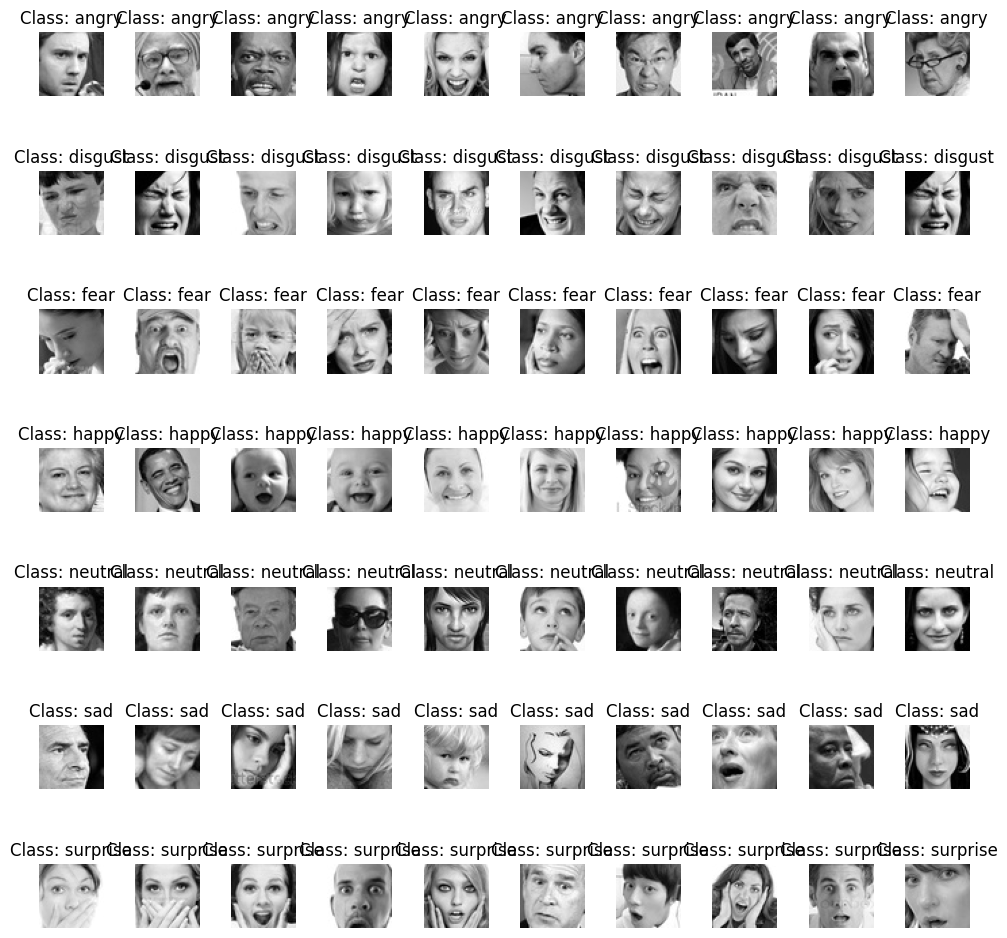

In [7]:
classes_to_plot = 7
images_per_class = 10
fig, axs = plt.subplots(classes_to_plot, images_per_class, figsize=(12, 12))

for i, label in enumerate(df['labels'].unique()):
    class_data = df[df['labels'] == label].head(images_per_class)
    for j, (_, row) in enumerate(class_data.iterrows()):
        ax = axs[i, j]
        ax.imshow(row['images'], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Class: {label}')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

<Axes: xlabel='labels'>

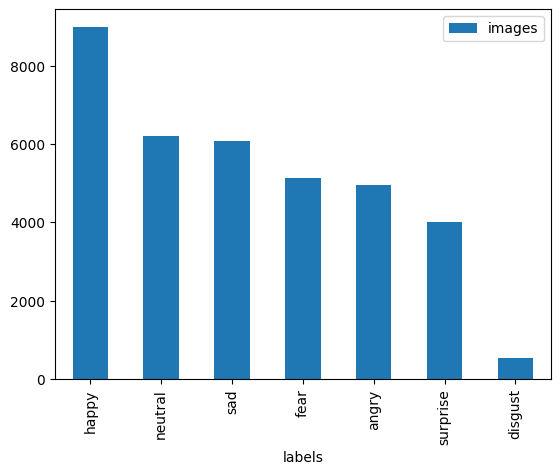

In [8]:
df.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

In [9]:
df=df.sample(frac=1,random_state=0)
train,temp=train_test_split(df, test_size=0.3, random_state=0,shuffle=True,stratify=df["labels"])
val,test=train_test_split(temp, test_size=0.3, random_state=0,shuffle=True,stratify=temp["labels"])

C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

## Oversampling

In [10]:
oversample=RandomOverSampler(sampling_strategy="auto",random_state=0)
X_over, y_over = oversample.fit_resample( train[["images"]], train[["labels"]])

C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\eli\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

In [11]:
frames = [X_over, y_over]
train_oversampled = pd.concat(frames,axis=1)
train_oversampled =train_oversampled.sample(frac=1,random_state=0)

In [12]:
train_oversampled

,images,labels
19959,"[[51, 60, 45, 31, 40, 39, 43, 41, 50, 78, 40, ...",fear
15414,"[[206, 173, 172, 177, 182, 168, 217, 170, 148,...",fear
2293,"[[27, 28, 24, 18, 14, 13, 16, 22, 35, 50, 59, ...",sad
41704,"[[187, 174, 154, 159, 159, 156, 152, 157, 158,...",surprise
8242,"[[3, 1, 20, 103, 217, 132, 134, 154, 104, 148,...",angry
...,...,...
30403,"[[66, 35, 11, 16, 36, 53, 71, 88, 105, 121, 13...",disgust
21243,"[[254, 252, 169, 88, 81, 56, 96, 89, 78, 73, 9...",happy
42613,"[[158, 137, 153, 171, 195, 205, 196, 195, 181,...",surprise
43567,"[[149, 146, 146, 153, 162, 164, 164, 165, 158,...",surprise


<Axes: xlabel='labels'>

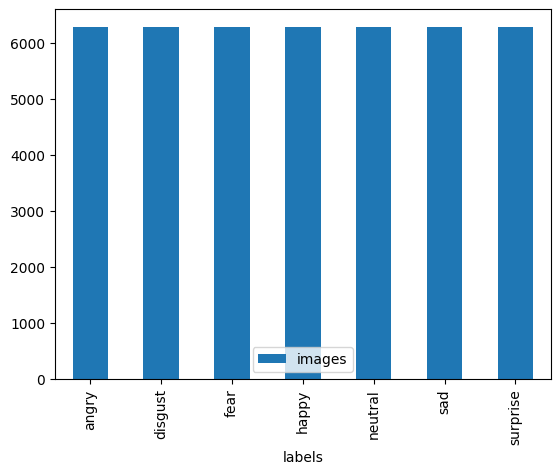

In [13]:
 train_oversampled.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

## Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
validation_datagen = ImageDataGenerator( 
      # rescale the pixel values (between 0 and 255) to the [0,1] interval 
       rescale=1./255
)

## Conversions to input format for models

In [15]:
np.array(train_oversampled['labels'])

array(['fear', 'fear', 'sad', ..., 'surprise', 'surprise', 'angry'],
      dtype=object)

In [16]:
# Schritt 1: "images" in einen NumPy ndarray umwandeln
X_train = np.array(train_oversampled['images'].tolist())

# Schritt 2: "labels" in einen NumPy ndarray umwandeln
y_train = np.array(train_oversampled['labels'])

# Überprüfung der Form der erstellten Arrays
print("Shape von X_train:", X_train.shape)
print("Shape von y_train:", y_train.shape)

Shape von X_train: (44044, 48, 48)
Shape von y_train: (44044,)


In [17]:
train_oversampled['labels']

19959        fear
15414        fear
2293          sad
41704    surprise
8242        angry
           ...   
30403     disgust
21243       happy
42613    surprise
43567    surprise
2732        angry
Name: labels, Length: 44044, dtype: object

In [18]:
mapping = {'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6}
train_oversampled['labels'] = train_oversampled['labels'].map(mapping)
#X_train = np.array(train_oversampled['images'].tolist()
X_train_plot=np.expand_dims(X_train[10].reshape((1,) + X_train[1].shape), axis=-1)
X_train=np.stack(train_oversampled["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_train=np.expand_dims(X_train, axis=-1)
y_train=train_oversampled["labels"].values

In [19]:
X_val=np.stack(val["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_val=np.expand_dims(X_val, axis=-1)
val["labels"]=val["labels"].map(mapping)
y_val=val["labels"].values

In [20]:
X_train_plot.shape

(1, 48, 48, 1)

In [21]:
y_train_cat=to_categorical(y_train)
y_train_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
y_val_cat=to_categorical(y_val)
y_val_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

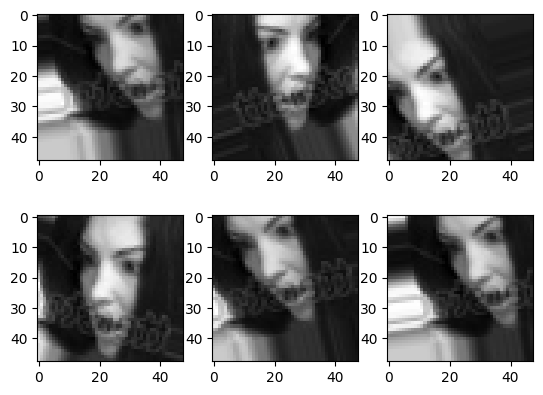

In [23]:
def plotImages(x):
    i = 1
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2,3,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray')
        i += 1
        if i % 7 == 0:
            break
    plt.show()

plotImages(X_train_plot)

### Up to here, the same preparatory steps were done as for the other emotion detection models.

# Part II - Emotion detection by using VGG16

Insights to VGG16:
https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918     

## Comparison of the models and final choice

Below is the overview of the five runs of VGG16() with its evaluation metrics and runtime.

In the __first run__, all layers of the pretrained model were frozen and four additional layers were added. The model was trained in 10 epochs and resulted in an accuracy of 0.3455. The curves in the graphs of the evaluation metrics do not transition into a horizontal line on the right edge. This means that further epochs might improve accuracy.

As enhancement for the __second run__, 4 layers at the end of the pretrained model were set as trainable (and not frozen as in the previous run). This prolonged the running time from about 20 minutes of the first run to about 50 minutes. The accuracy improved to 0.5724 and the curves of validation accuracy and validation loss turn into a more horizontal line at the right edge. 

The __third run__ was trained 9 additional layers, keeping the four last layers of VGG16() as trainable. The epochs have been raised from 10 to 100, which resulted in a runtime of more than 8 hours. The accuracy improved to 0.7598 but the metrics graphs show overfitting.

To reduce  overfitting, the dropout rate was set from 0.3 to 0.5 in the __fourth run__, and L2-Regualtization was introduced. The accuracy is 0.7644 and the metric graphs still show overfitting.

For the __fifth run__, the number of filters in the Conv2D-layer were reduced from 128 to 64 and the number of neurons in the Dense-layer were reduced from 256 to 128. In addition the dropout rate was increased to 0.7 (from previously 0.5). With those adaptions, the overfitting could be reduced as can be seen in the evaluation graphs, but this model reduces the accuracy = 0.6748 as well.

For our final style transfer on pictures with detected faces and their emotions, the fourth model was chosen as it had best performance despite of showing more overfitting.

In [ ]:
# Overview of metrics and runtime of the models

# for 1st run:
# Epoch 10/10
# 1102/1102 [==============================] - 118s 107ms/step - 
# loss: 1.7159 - categorical_accuracy: 0.3317 - 
# val_loss: 1.7440 - val_categorical_accuracy: 0.3092
# Duration of model-fit in minutes: 19.2131
# Epoch 10/10
# 1102/1102 [==============================] - 122s 111ms/step - 
# loss: 1.7044 - categorical_accuracy: 0.3395 - accuracy: 0.3395 - 
# val_loss: 1.7260 - val_categorical_accuracy: 0.3212 - val_accuracy: 0.3212

# for 2nd run:
# Epoch 10/10
# 1102/1102 [==============================] - 270s 245ms/step - 
# loss: 1.0826 - categorical_accuracy: 0.5918 - 
# val_loss: 1.2782 - val_categorical_accuracy: 0.5222
# Epoch 10/10
# 1102/1102 [==============================] - 266s 242ms/step - 
# loss: 1.0615 - categorical_accuracy: 0.6041 - val_loss: 1.2859 - 
# val_categorical_accuracy: 0.4944

# for 3rd try:


# for 4th try:


# for 5th try:


# Code for all five iterations:

VGG16 expects the input to be 224x224x3. As we have greyscale images to train on having only one channel, we replicate this one channel to three channels.
The size of our images (48x48) will not be adapted (resized). An attempt to resize the images to 224x224 was made after the thrid run of the model, but was then given up and not finalized, as I continouosly got a 'ResourceExhaustedError'.

# First run: all layers freezed, 10 epochs, 4 additional layers

VGG16 expects the input to be 224x224x3. As we have greyscale images to train on haveing only one channel, we replicate this one channel to three channels.
The size of our images (48x48) will only be adapted in the fourth run.

In [51]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1) 

In [52]:
# train and test-generator
train_generator = train_datagen.flow(
    x=X_train_rgb, 
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_val_rgb, 
    y=y_val_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [53]:
# 1st and 2nd run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7  
learning_rate = 0.0001
batch_size = 32
epochs = 10                  

In [54]:
# Load the pretrained VGG16-model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [55]:
# 1-st run: Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [56]:
# 1st and 2nd run: Add custom layers for emotion classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [57]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [58]:
# define metrics 
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()
loss = tf.keras.losses.CategoricalCrossentropy()

In [59]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss,
              metrics=[metric_accuracy, 'accuracy'])

In [60]:
# Train the model
start = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

end = time.time()

Epoch 1/10
1102/1102 [==============================] - 105s 95ms/step - loss: 1.9269 - categorical_accuracy: 0.2161 - accuracy: 0.2161 - val_loss: 1.8296 - val_categorical_accuracy: 0.2641 - val_accuracy: 0.2641
Epoch 2/10
1102/1102 [==============================] - 109s 99ms/step - loss: 1.8244 - categorical_accuracy: 0.2722 - accuracy: 0.2722 - val_loss: 1.7896 - val_categorical_accuracy: 0.2953 - val_accuracy: 0.2953
Epoch 3/10
1102/1102 [==============================] - 108s 98ms/step - loss: 1.7957 - categorical_accuracy: 0.2885 - accuracy: 0.2885 - val_loss: 1.8014 - val_categorical_accuracy: 0.2661 - val_accuracy: 0.2661
Epoch 4/10
1102/1102 [==============================] - 112s 102ms/step - loss: 1.7715 - categorical_accuracy: 0.3015 - accuracy: 0.3015 - val_loss: 1.7875 - val_categorical_accuracy: 0.2747 - val_accuracy: 0.2747
Epoch 5/10
1102/1102 [==============================] - 114s 104ms/step - loss: 1.7549 - categorical_accuracy: 0.3115 - accuracy: 0.3115 - val_loss

In [44]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))
# Duration of model-fit in minutes: 19.2131

Duration of model-fit in minutes: 19.2131


In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### 1st run:

Model: "model_1"  
_________________________________________________________________  

### Layer (type)                Output Shape              Param   
=================================================================  
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================  
Total params: 14,847,815  
Trainable params: 133,127  
Non-trainable params: 14,714,688  
_________________________________________________________________

In [49]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [50]:
# 1st run: metrics overview
acc = history.history['categorical_accuracy'][-1]
val_acc = history.history['val_categorical_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Loss:', round(val_loss,4))

# Training Accuracy: 0.3326
# Validation Accuracy: 0.3455 
# Training Loss: 1.8324
# Validation Accuracy: 1.7829

Training Accuracy: 0.3317
Validation Accuracy: 0.3092 

Training Loss: 1.8267
Validation Accuracy: 1.8119


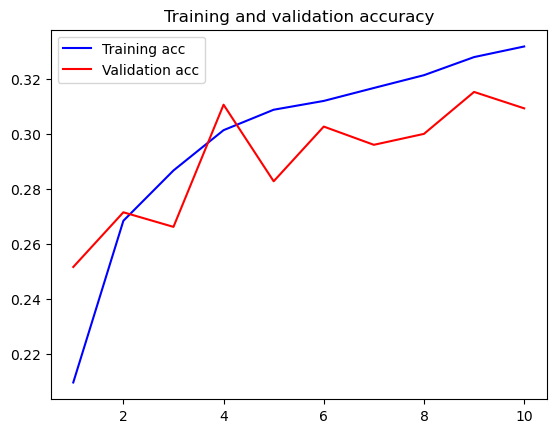

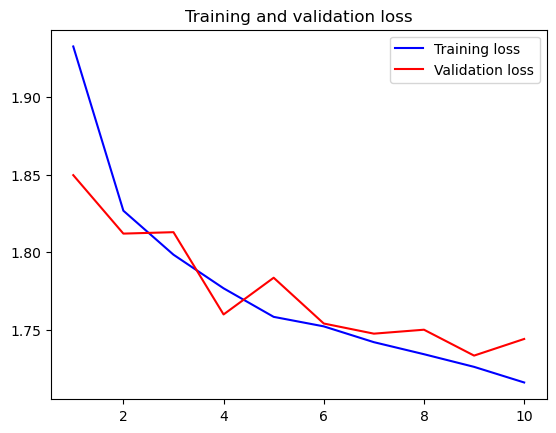

In [51]:
# plot accuracy and loss
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
# Save the model for future inference
model.save('1st_run_VGG16_model.h5')

### Evaluate and get Confusion Matrix

In [55]:
model.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 20s 86ms/step - loss: 30.6578 - categorical_accuracy: 0.2151


[30.65781593322754, 0.21510085463523865]

In [58]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [59]:
X_test.shape

(3231, 48, 48, 1)

In [60]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_test_rgb = np.repeat(X_test, 3, -1)  # Replicate single channel to three channels

In [61]:
predicted=np.argmax(model.predict(X_test_rgb), axis=1)
predicted

101/101 [==============================] - 8s 81ms/step


array([4, 4, 0, ..., 4, 4, 4], dtype=int64)

In [62]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

0       neutral
1       neutral
2         angry
3          fear
4         angry
         ...   
3226    neutral
3227    neutral
3228    neutral
3229    neutral
3230    neutral
Name: 0, Length: 3231, dtype: object

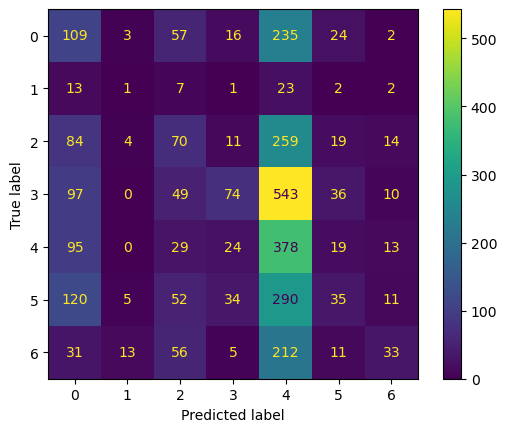

Accuracy: 0.2166511915815537
Recall: [0.24439462 0.02040816 0.15184382 0.09147095 0.67741935 0.06398537
 0.09141274]
Precision: [0.19854281 0.03846154 0.21875    0.44848485 0.19484536 0.23972603
 0.38823529]
Precision: [0.21909548 0.02666667 0.17925736 0.15195072 0.30264211 0.1010101
 0.14798206]


In [63]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)

# Second run: 4 trainable layers at the end, 10 epochs, 4 additional layers

In [27]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1) 

In [29]:
# 1st and 2nd run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7  
learning_rate = 0.0001
batch_size = 32
epochs = 10 

In [30]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_rgb, 
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_val_rgb, 
    y=y_val_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [31]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [32]:
# 2nd run: only freezing layers at the beginning and fine-tune some of the later layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False  

In [33]:
# 1st and 2nd run: Add custom layers for emotion classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [34]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [35]:
# define metrics 
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()
loss = tf.keras.losses.CategoricalCrossentropy()

In [36]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss,
              metrics=[metric_accuracy])

In [37]:
# Train the model
start = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

end = time.time()

Epoch 1/10
1102/1102 [==============================] - 278s 252ms/step - loss: 1.7248 - categorical_accuracy: 0.3194 - val_loss: 1.6437 - val_categorical_accuracy: 0.3563
Epoch 2/10
1102/1102 [==============================] - 291s 264ms/step - loss: 1.4991 - categorical_accuracy: 0.4331 - val_loss: 1.5280 - val_categorical_accuracy: 0.4114
Epoch 3/10
1102/1102 [==============================] - 278s 252ms/step - loss: 1.3946 - categorical_accuracy: 0.4758 - val_loss: 1.4604 - val_categorical_accuracy: 0.4380
Epoch 4/10
1102/1102 [==============================] - 265s 241ms/step - loss: 1.3115 - categorical_accuracy: 0.5071 - val_loss: 1.3895 - val_categorical_accuracy: 0.4632
Epoch 5/10
1102/1102 [==============================] - 260s 236ms/step - loss: 1.2480 - categorical_accuracy: 0.5295 - val_loss: 1.5119 - val_categorical_accuracy: 0.4194
Epoch 6/10
1102/1102 [==============================] - 264s 240ms/step - loss: 1.2012 - categorical_accuracy: 0.5489 - val_loss: 1.3394 - v

In [38]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))
# Duration of model-fit in minutes: 44.8161
# Duration of model-fit in minutes: 45.3845

Duration of model-fit in minutes: 45.3845


In [75]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### 2nd run:

Model: "model_2"  
_________________________________________________________________  
### Layer (type)                Output Shape              Param #   
=================================================================  
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================  
Total params: 14,847,815  
Trainable params: 7,212,551  
Non-trainable params: 7,635,264  
_________________________________________________________________

In [39]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [40]:
# 2nd run: metrics overview
acc = history.history['categorical_accuracy'][-1]
val_acc = history.history['val_categorical_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Accuracy:', round(val_loss,4))

# Training Accuracy: 0.5918
# Validation Accuracy: 0.5222 
# Training Loss: 1.5456
# Validation Accuracy: 1.5667

# Training Accuracy: 0.6041
# Validation Accuracy: 0.4944 
# Training Loss: 1.4991
# Validation Accuracy: 1.528


Training Accuracy: 0.6041
Validation Accuracy: 0.4944 

Training Loss: 1.4991
Validation Accuracy: 1.528


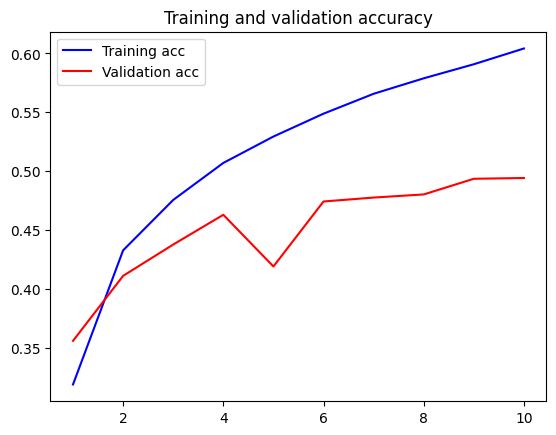

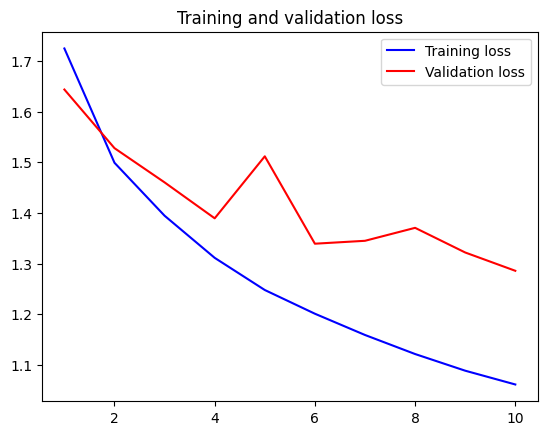

In [41]:
# 2nd run metrics plot:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [42]:
# Save the model for future inference
model.save('2nd_run_VGG16_model.h5')

### Evaluate and get Confusion Matrix

In [43]:
model.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 19s 80ms/step - loss: 99.9801 - categorical_accuracy: 0.3672


[99.98014831542969, 0.36717090010643005]

In [44]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [45]:
X_test.shape

(3231, 48, 48, 1)

In [46]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_test_rgb = np.repeat(X_test, 3, -1)  # Replicate single channel to three channels

In [47]:
predicted=np.argmax(model.predict(X_test_rgb), axis=1)
predicted

101/101 [==============================] - 8s 80ms/step


array([3, 3, 3, ..., 0, 3, 2], dtype=int64)

In [48]:
predicted.shape

(3231,)

In [49]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

0       happy
1       happy
2       happy
3       happy
4         sad
        ...  
3226    happy
3227     fear
3228    angry
3229    happy
3230     fear
Name: 0, Length: 3231, dtype: object

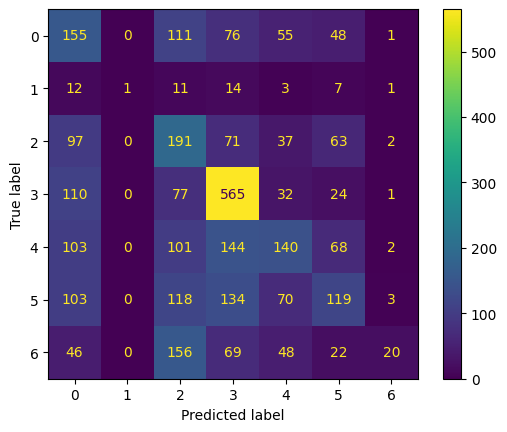

Accuracy: 0.3686165273909007
Recall: [0.34753363 0.02040816 0.4143167  0.69839308 0.25089606 0.21755027
 0.05540166]
Precision: [0.24760383 1.         0.2496732  0.52656104 0.36363636 0.33903134
 0.66666667]
Precision: [0.2891791  0.04       0.31158238 0.60042508 0.29692471 0.26503341
 0.10230179]


In [50]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)

# Third run: 4 trainable layers at the end, add more additional layers, 100 epochs

In [62]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1) 

In [63]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_rgb, 
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_val_rgb, 
    y=y_val_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [64]:
# 3rd run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7  
learning_rate = 0.0001
batch_size = 32
epochs = 100                  

In [65]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [38]:
# 1-st run: Freeze all layers of the base model
#for layer in base_model.layers:
#    layer.trainable = False

In [66]:
# 2nd and 3rd try: freeze layers at the beginning and fine-tune the last 4 layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False  

In [67]:
# 3rd run: add custom layers for emotion classification
x = Conv2D(128, (3,3),padding = 'same')(base_model.output)       # oder Conv1D(128, (3,3),padding = 'same')(base_model.output)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [68]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [71]:
# define metrics 
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()
loss = tf.keras.losses.CategoricalCrossentropy()

In [72]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss,
              metrics=[metric_accuracy])

In [ ]:
# for 1st try:
# Epoch 10/10
# 1102/1102 [==============================] - 140s 127ms/step - 
# loss: 1.6683 - accuracy: 0.3507 - val_loss: 1.6371 - val_accuracy: 0.3647

# for 2nd try:
# Epoch 10/10
# 1102/1102 [==============================] - 304s 276ms/step - 
# loss: 1.0942 - accuracy: 0.5903 - val_loss: 1.1315 - val_accuracy: 0.5724

# for 3rd try:
# Epoch 100/100
# 1102/1102 [==============================] - 283s 257ms/step - 
# loss: 0.3115 - accuracy: 0.8947 - val_loss: 0.8834 - val_accuracy: 0.7598

# for 4th try:
# Epoch 100/100
# 1102/1102 [==============================] - 285s 259ms/step - 
# loss: 0.3134 - accuracy: 0.9001 - val_loss: 0.8656 - val_accuracy: 0.7644

# for 5th try:
# Epoch 100/100
# 1102/1102 [==============================] - 275s 249ms/step - 
# loss: 0.7875 - accuracy: 0.7455 - val_loss: 0.9641 - val_accuracy: 0.6748

In [73]:
# Train the model
start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    callbacks=[early_stopping]
)

end = time.time()


Epoch 1/100
1102/1102 [==============================] - 289s 262ms/step - loss: 1.8145 - categorical_accuracy: 0.2957 - val_loss: 1.8119 - val_categorical_accuracy: 0.2906
Epoch 2/100
1102/1102 [==============================] - 320s 290ms/step - loss: 1.6028 - categorical_accuracy: 0.3897 - val_loss: 1.6891 - val_categorical_accuracy: 0.3597
Epoch 3/100
1102/1102 [==============================] - 328s 298ms/step - loss: 1.5134 - categorical_accuracy: 0.4287 - val_loss: 1.5077 - val_categorical_accuracy: 0.4127
Epoch 4/100
1102/1102 [==============================] - 279s 253ms/step - loss: 1.4437 - categorical_accuracy: 0.4586 - val_loss: 1.5289 - val_categorical_accuracy: 0.4161
Epoch 5/100
1102/1102 [==============================] - 283s 256ms/step - loss: 1.3818 - categorical_accuracy: 0.4852 - val_loss: 1.3950 - val_categorical_accuracy: 0.4645
Epoch 6/100
1102/1102 [==============================] - 280s 254ms/step - loss: 1.3375 - categorical_accuracy: 0.5020 - val_loss: 1.39

In [74]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))
# 2nd try: Duration of model-fit in minutes: 51.3443
# 3rd try: Duration of model-fit in minutes: 509.6655
# 4th try: Duration of model-fit in minutes: 474.4977
# 3rd run with EarlyStopping: Duration of model-fit in minutes: 71.11


Duration of model-fit in minutes: 71.11


In [75]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### 3rd run:

Model: "model_4"
_________________________________________________________________
### Layer (type)                Output Shape              Param #     
=================================================================  
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 128)         589952    
                                                                 
 batch_normalization_5 (Batc  (None, 1, 1, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 1, 1, 128)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================  
Total params: 15,339,975  
Trainable params: 7,704,455  
Non-trainable params: 7,635,520  
_________________________________________________________________



In [76]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [77]:
# 3rd run: metrics overview
acc = history.history['categorical_accuracy'][-1]
val_acc = history.history['val_categorical_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Loss:', round(val_loss,4))

Training Accuracy: 0.5951
Validation Accuracy: 0.4937 

Training Loss: 1.6028
Validation Loss: 1.6891


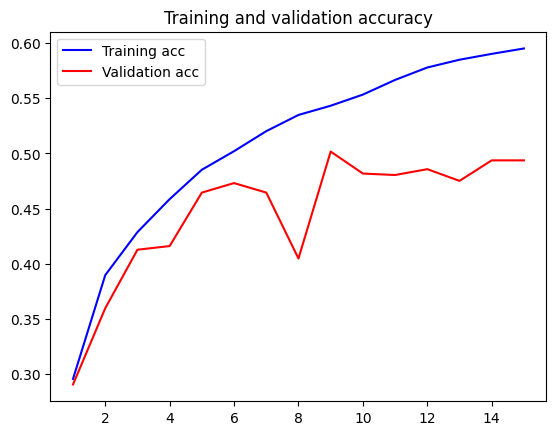

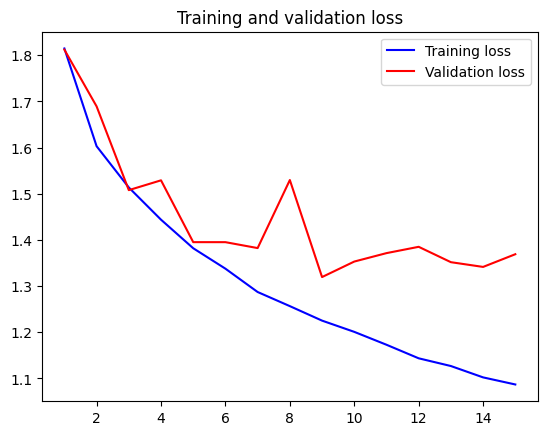

In [78]:
# 3rd run metrics plot:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [81]:
# Save the model for future inference
model.save('3rd_run_VGG16_model.h5')

### Evaluate and get Confusion Matrix

In [80]:
model.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 20s 85ms/step - loss: 54.6277 - categorical_accuracy: 0.3873


[54.62770080566406, 0.3873407542705536]

In [82]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [83]:
X_test.shape

(3231, 48, 48, 1)

In [84]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_test_rgb = np.repeat(X_test, 3, -1)  # Replicate single channel to three channels

In [85]:
predicted=np.argmax(model.predict(X_test_rgb), axis=1)
predicted

101/101 [==============================] - 8s 82ms/step


array([4, 3, 3, ..., 4, 3, 2], dtype=int64)

In [86]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

0       neutral
1         happy
2         happy
3         happy
4          fear
         ...   
3226      happy
3227       fear
3228    neutral
3229      happy
3230       fear
Name: 0, Length: 3231, dtype: object

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)

# Fourth run: 4 trainable layers at the end, adapting additional layers, 100 epochs

dropout = 0.5 (before = 0.3)  
add L2-regularization  
epochs = 100   (as before)

In [24]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1) 

In [25]:
# 4th run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7  
learning_rate = 0.0001
batch_size = 32
epochs = 100     

In [26]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_rgb, 
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_val_rgb, 
    y=y_val_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [27]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [28]:
# 4th run: freeze layers at the beginning and fine-tune the last 4 layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False  

In [29]:
# 4th run: add custom layers for emotion classification
x = Conv2D(128, (3,3),padding = 'same')(base_model.output)       
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)
x = Dropout(0.5)(x)                                                   # adapted 0.3 -> 0.5
x = Flatten()(x)
#x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)     # added L2-regulation
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax', )(x)

In [30]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [31]:
# define metrics 
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()
loss = tf.keras.losses.CategoricalCrossentropy()

In [32]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss,
              metrics=[metric_accuracy, 'accuracy'])

In [33]:
# Train the model
start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    callbacks=[early_stopping]
)

end = time.time()

Epoch 1/100
1102/1102 [==============================] - 269s 243ms/step - loss: 3.2632 - categorical_accuracy: 0.2664 - accuracy: 0.2664 - val_loss: 3.0803 - val_categorical_accuracy: 0.1971 - val_accuracy: 0.1971
Epoch 2/100
1102/1102 [==============================] - 265s 240ms/step - loss: 2.5047 - categorical_accuracy: 0.3667 - accuracy: 0.3667 - val_loss: 2.3105 - val_categorical_accuracy: 0.3822 - val_accuracy: 0.3822
Epoch 3/100
1102/1102 [==============================] - 259s 235ms/step - loss: 2.0603 - categorical_accuracy: 0.4183 - accuracy: 0.4183 - val_loss: 1.9644 - val_categorical_accuracy: 0.4107 - val_accuracy: 0.4107
Epoch 4/100
1102/1102 [==============================] - 258s 234ms/step - loss: 1.7931 - categorical_accuracy: 0.4474 - accuracy: 0.4474 - val_loss: 1.7130 - val_categorical_accuracy: 0.4326 - val_accuracy: 0.4326
Epoch 5/100
1102/1102 [==============================] - 280s 254ms/step - loss: 1.6106 - categorical_accuracy: 0.4776 - accuracy: 0.4776 - 

In [34]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))

# Duration of model-fit in minutes: 474.4977
# Duration of model-fit in minutes: 466.9881
# EarlyStopping 15: Duration of model-fit in minutes: 163.7223


Duration of model-fit in minutes: 163.7223


In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

##  4th run:

Model: "model"
_________________________________________________________________
### Layer (type)                Output Shape              Param #   
=================================================================  
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 128)         589952    
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 1, 128)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 128)         0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================  
Total params: 15,339,975  
Trainable params: 7,704,455  
Non-trainable params: 7,635,520  
_________________________________________________________________  
 


In [46]:
# 4th run: metrics overview
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Loss:', round(val_loss,4))

# Training Accuracy: 0.9001
# Validation Accuracy: 0.7644 
# Training Loss: 2.5809
# Validation Accuracy: 2.3178

#Training Accuracy: 0.8729
#Validation Accuracy: 0.7425 
#Training Loss: 2.2153
#Validation Accuracy: 1.9925

# Early Stopping 15
# Training Accuracy: 0.7253
# Validation Accuracy: 0.5003 
# Training Loss: 2.5047
# Validation Loss: 2.3105


Training Accuracy: 0.7253
Validation Accuracy: 0.5003 

Training Loss: 2.5047
Validation Loss: 2.3105


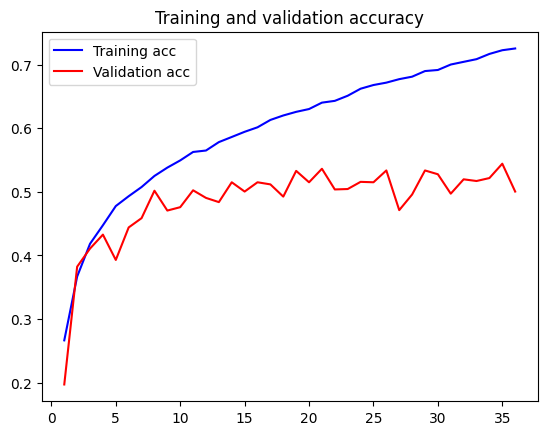

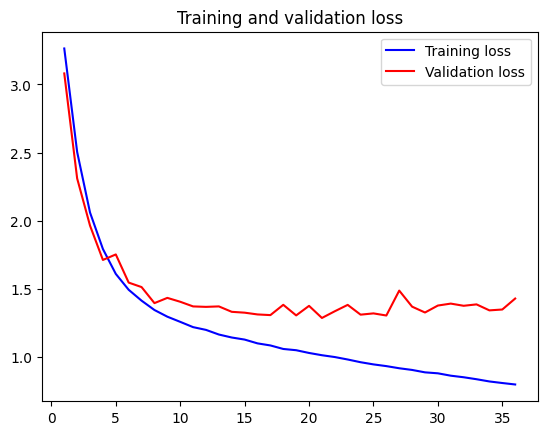

In [37]:
# 4th run metrics plot:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [38]:
# Save the model for future inference
model.save('4tht_run_VGG16_model_ES15.h5')


### Evaluate and get Confusion Matrix

In [39]:
model.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 20s 85ms/step - loss: 50.7247 - categorical_accuracy: 0.3937 - accuracy: 0.3937


[50.72466278076172, 0.393710196018219, 0.393710196018219]

In [40]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [41]:
X_test.shape

(3231, 48, 48, 1)

In [42]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_test_rgb = np.repeat(X_test, 3, -1)  # Replicate single channel to three channels

In [43]:
predicted=np.argmax(model.predict(X_test_rgb), axis=1)
predicted

101/101 [==============================] - 9s 86ms/step


array([5, 3, 0, ..., 5, 3, 2], dtype=int64)

In [44]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

0         sad
1       happy
2       angry
3       angry
4        fear
        ...  
3226      sad
3227      sad
3228      sad
3229    happy
3230     fear
Name: 0, Length: 3231, dtype: object

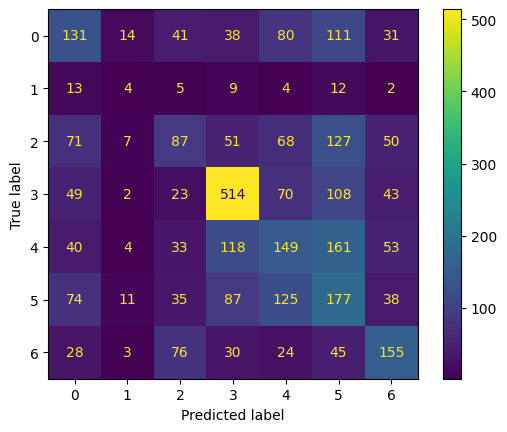

Accuracy: 0.3766635716496441
Recall: [0.29372197 0.08163265 0.18872017 0.63535229 0.26702509 0.32358318
 0.42936288]
Precision: [0.3226601  0.08888889 0.29       0.6068477  0.28653846 0.2388664
 0.41666667]
Precision: [0.30751174 0.08510638 0.22864652 0.62077295 0.27643785 0.27484472
 0.42291951]


In [45]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)

# Fifth run: 4 trainable layers at the end, adapting additional layers, 100 epochs


Conv2D: less filters, only 64
Dens: reduce to 128 neurons  
Dropout to 0.7  
L2 strength to 0.001  

In [47]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1) 

In [48]:
# 5th run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7  
learning_rate = 0.0001
batch_size = 32
epochs = 100 

In [49]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_rgb, 
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_val_rgb, 
    y=y_val_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [50]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [51]:
# 5th run: freeze layers at the beginning and fine-tune the last 4 layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False  

In [52]:
# 5th run: add custom layers for emotion classification
x = Conv2D(64, (3,3),padding = 'same')(base_model.output)              # from 128 to 64 filters 
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((1, 1))(x) 
x = Dropout(0.7)(x)                                                    # 0.5 to 0.7
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)     # 256 to 128 neurons, L2 dtrength 0.01 to 0.001
x = Dropout(0.7)(x)                                                    # 0.5 to 0.7  
output = Dense(num_classes, activation='softmax', )(x)

In [53]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [54]:
# define metrics 
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()
loss = tf.keras.losses.CategoricalCrossentropy()

In [55]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
# Train the model
start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    callbacks=[early_stopping]
)

end = time.time()

Epoch 1/100
1102/1102 [==============================] - 269s 243ms/step - loss: 2.1010 - accuracy: 0.1518 - val_loss: 2.0500 - val_accuracy: 0.1659
Epoch 2/100
1102/1102 [==============================] - 262s 237ms/step - loss: 1.9726 - accuracy: 0.2096 - val_loss: 1.9520 - val_accuracy: 0.2269
Epoch 3/100
1102/1102 [==============================] - 247s 224ms/step - loss: 1.8621 - accuracy: 0.2895 - val_loss: 1.9030 - val_accuracy: 0.2681
Epoch 4/100
1102/1102 [==============================] - 247s 224ms/step - loss: 1.7855 - accuracy: 0.3274 - val_loss: 1.7508 - val_accuracy: 0.3411
Epoch 5/100
1102/1102 [==============================] - 248s 225ms/step - loss: 1.7250 - accuracy: 0.3583 - val_loss: 1.6774 - val_accuracy: 0.3530
Epoch 6/100
1102/1102 [==============================] - 248s 225ms/step - loss: 1.6656 - accuracy: 0.3812 - val_loss: 1.7164 - val_accuracy: 0.3411
Epoch 7/100
1102/1102 [==============================] - 248s 225ms/step - loss: 1.6226 - accuracy: 0.3947

Epoch 56/100
1102/1102 [==============================] - 268s 243ms/step - loss: 1.0344 - accuracy: 0.6316 - val_loss: 1.3157 - val_accuracy: 0.5176
Epoch 57/100
1102/1102 [==============================] - 267s 242ms/step - loss: 1.0349 - accuracy: 0.6306 - val_loss: 1.3552 - val_accuracy: 0.5163
Epoch 58/100
1102/1102 [==============================] - 269s 244ms/step - loss: 1.0259 - accuracy: 0.6353 - val_loss: 1.3203 - val_accuracy: 0.5202
Epoch 59/100
1102/1102 [==============================] - 267s 242ms/step - loss: 1.0201 - accuracy: 0.6407 - val_loss: 1.3917 - val_accuracy: 0.4964
Epoch 60/100
1102/1102 [==============================] - 266s 241ms/step - loss: 1.0119 - accuracy: 0.6439 - val_loss: 1.3499 - val_accuracy: 0.4964
Epoch 61/100
1102/1102 [==============================] - 268s 243ms/step - loss: 1.0105 - accuracy: 0.6454 - val_loss: 1.4234 - val_accuracy: 0.5017
Epoch 62/100
1102/1102 [==============================] - 267s 242ms/step - loss: 0.9996 - accuracy:

In [57]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))

# Duration of model-fit in minutes: 457.1054

Duration of model-fit in minutes: 395.255


In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

## 5th run:

Model: "model"
_________________________________________________________________ 
### Layer (type)                Output Shape              Param #   
=================================================================  
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 64)          294976    
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 64)         256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 1, 64)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
=================================================================  
Total params: 15,019,143  
Trainable params: 7,383,751  
Non-trainable params: 7,635,392  
_________________________________________________________________  

In [77]:
# 5th run: metrics overview
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Loss:', round(val_loss,4))

# Training Accuracy: 0.7455
# Validation Accuracy: 0.6748 
# Training Loss: 1.9403
# Validation Accuracy: 1.8504

# Early Stopping
# Training Accuracy: 0.7116
# Validation Accuracy: 0.4791 
# Training Loss: 1.9726
# Validation Loss: 1.952


Training Accuracy: 0.7116
Validation Accuracy: 0.4791 

Training Loss: 1.9726
Validation Loss: 1.952


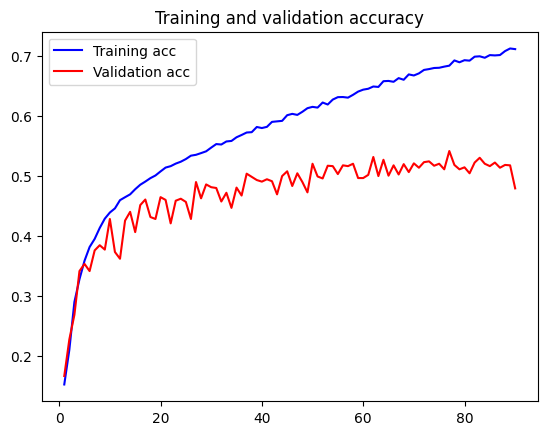

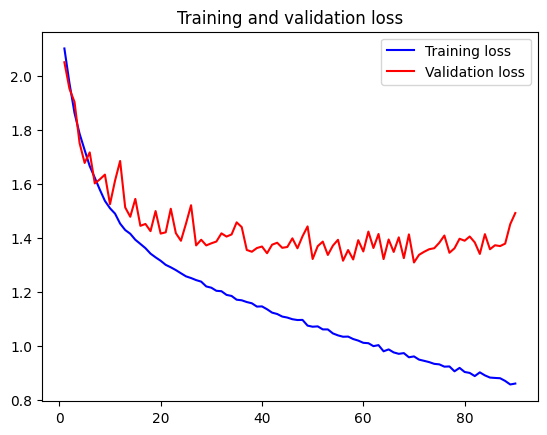

In [60]:
# 5th run metrics plot:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [61]:
# Save the model for future inference
model.save('5th_run_VGG16_model_ES20.h5')

### Evaluate and get Confusion Matrix

In [69]:
model.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 30s 126ms/step - loss: 88.1422 - accuracy: 0.3424


[88.14218139648438, 0.34235668182373047]

In [70]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [71]:
X_test.shape

(3231, 48, 48, 1)

In [72]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_test_rgb = np.repeat(X_test, 3, -1)  # Replicate single channel to three channels

In [73]:
predicted=np.argmax(model.predict(X_test_rgb), axis=1)
predicted

101/101 [==============================] - 12s 117ms/step


array([4, 5, 0, ..., 5, 3, 5], dtype=int64)

In [74]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

0       neutral
1           sad
2         angry
3         angry
4         angry
         ...   
3226        sad
3227        sad
3228        sad
3229      happy
3230        sad
Name: 0, Length: 3231, dtype: object

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)